# Kaggle -- Toxic Comment Classification Challenge

Goal: build a multi-headed model to detect different types of of toxicity of online comments (from Wikipedia), there are 6 categories: toxic, severe-toxic, insult, obscene, threat, identity_hate.

Model: SVM, logistic regression


### 1. Data Preprocessing

In [0]:
import re
from collections import Counter

import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.sparse as sps
import sklearn.svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import pandas as pd

%matplotlib inline


In [2]:
# file_path = 'data/'
file_path = 'drive/My Drive/Colab_Notebooks/'
dat = pd.read_csv(file_path + 'train.csv')
dat.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
dat.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [4]:
dat.shape

(159571, 8)

In [0]:
n = dat.shape[0]

In [0]:
X_raw = dat['comment_text']
y_raw = dat.loc[ : ,'toxic':'identity_hate']

## Binary Classification first

First try to classify the comment into two categories which are toxic and non-toxic, instead of 6.

Mark a row as 1 if any of the labels are assigned to this row

In [0]:
y = y_raw.any(axis=1) * 2 - 1
y = y.values

frequency table of y, non-toxic is 9~10 times more than toxic comments

In [8]:
Counter(y)

Counter({-1: 143346, 1: 16225})

Extract X, a 0-1 vector of words

In [0]:
split_s = re.compile(r"[a-z]+", re.IGNORECASE)

In [0]:
X_raw1 = X_raw.apply(lambda s: split_s.findall(s.lower()))

In [11]:
X_raw1.head(5)

0    [explanation, why, the, edits, made, under, my...
1    [d, aww, he, matches, this, background, colour...
2    [hey, man, i, m, really, not, trying, to, edit...
3    [more, i, can, t, make, any, real, suggestions...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: comment_text, dtype: object

Construct a Counter object to store words and their counts; 

In [0]:
word_dict = Counter()

for i in range(n):
    word_dict.update(X_raw1[i])


In [13]:
{k: word_dict[k] for k in list(word_dict)[:10]}

{'edits': 9995,
 'explanation': 1771,
 'hardcore': 167,
 'made': 9685,
 'metallica': 39,
 'my': 45665,
 'the': 497217,
 'under': 7013,
 'username': 1826,
 'why': 17871}

In [14]:
len(word_dict)

168900

Remove the words with counts smaller than or equal to 10, number of words significantly decreases

In [0]:
word_dict = {k: word_dict[k] for k in list(word_dict) if word_dict[k] > 10}

In [16]:
len(word_dict)

24735

In [0]:
word_dict = {k: v for k, v in sorted(word_dict.items(),reverse = True, key = lambda kv: kv[1])}

In [18]:
{k: word_dict[k] for k in list(word_dict)[:10]}

{'a': 217526,
 'and': 224301,
 'i': 240653,
 'is': 176503,
 'it': 148666,
 'of': 225084,
 'that': 160879,
 'the': 497217,
 'to': 297521,
 'you': 218701}

Construct a stop word array for the those noninformative words, such as "the", "to"; select these words from the most frequent 150 words

In [19]:
stop_list = list(word_dict.keys())[:150]
print(stop_list)

['the', 'to', 'i', 'of', 'and', 'you', 'a', 'is', 'that', 'it', 'in', 'for', 'this', 'not', 'on', 'be', 'as', 's', 'have', 'are', 'your', 't', 'with', 'if', 'article', 'was', 'or', 'but', 'wikipedia', 'page', 'my', 'an', 'from', 'by', 'do', 'at', 'can', 'talk', 'me', 'about', 'so', 'what', 'there', 'all', 'has', 'will', 'please', 'no', 'they', 'would', 'he', 'one', 'like', 'just', 'we', 'which', 'any', 'been', 'should', 'don', 'more', 'some', 'other', 'here', 'who', 'see', 'also', 'his', 'm', 'think', 'because', 'know', 'how', 'people', 'am', 'edit', 'why', 'up', 'only', 'out', 'articles', 'use', 'when', 'then', 'time', 'may', 'were', 'did', 'them', 'now', 'user', 'being', 'their', 're', 'than', 'thanks', 'even', 'get', 'make', 'good', 'had', 'well', 'very', 've', 'information', 'does', 'could', 'want', 'deletion', 'its', 'such', 'sources', 'way', 'name', 'image', 'these', 'first', 'wp', 'help', 'pages', 'new', 'source', 'editing', 'go', 'section', 'need', 'say', 'fuck', 'again', 'edit

In [0]:
# manunally select from the top 150 frequent words
stop_list = ['the', 'to', 'i', 'of', 'and', 'you', 'a', 'is', 'that', 'it', 'in', 'for', 'this', 'not', 'on', 'be', 'as', 's', 'have', 'are', 'your', 't', 'with', 'if', 'article', 'articles', 'was', 'or', 'but', 'wikipedia', 'page', 'my', 'an', 'from', 'by', 'do', 'at', 'can', 'me', 'about', 'so', 'what', 'there', 'all', 'has', 'will', 'no', 'they', 'he', 'one', 'we', 'which', 'any', 'been', 'more', 'some', 'other', 'here', 'who', 'also', 'his', 'm', 'because', 'know', 'how', 'am', 'why', 'up', 'out', 'when', 'then', 'time', 'were', 'did', 'them', 'now', 'being', 'their', 're', 'than', 've', 'does', 'its', 'such', 'sources', 'way', 'name', 'image', 'these', 'first', 'wp', 'pages', 'again', 'where', 'many', 'much', 'used', 'most', 'into', 'd', 'those', 'before']

Remove words in the stop_list

In [0]:
filtered_words = [tup[0] for tup in word_dict.items()]
for word in stop_list:
    filtered_words.remove(word)
filtered_words = np.asarray(filtered_words)

Make Document-Term Matrix, each row is a document, the column is the whether the word occured in the document.
But the dimension is too high, use sparse matrix structure in scipy.sparse instead.

In [0]:
# no need to run every time, takes ~30 mins
X = sps.lil_matrix((n, filtered_words.shape[0]), dtype=np.float64)
for i in range(n):
    X[i, np.in1d(filtered_words, X_raw1[i])] = 1
# Save the X data for later use
sps.save_npz("X_data.npz", sps.coo_matrix(X))

In [0]:
X = sps.lil_matrix(sps.load_npz(file_path + "X_data.npz"))

#### Form the Document-Term Matrix for test data

In [23]:
dat_test = pd.read_csv(file_path + "test.csv")
dat_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
n_test = dat_test.shape[0]

In [0]:
X_test_raw = dat_test["comment_text"]

In [0]:
split_s = re.compile(r"[a-z]+", re.IGNORECASE)

In [0]:
X_test_raw1 = X_test_raw.apply(lambda s: split_s.findall(s.lower()))

In [0]:
# no need to run this every time
X_test = sps.lil_matrix((n_test, filtered_words.shape[0]), dtype=np.float64)
for i in range(n_test):
    X_test[i, np.in1d(filtered_words, X_raw1[i])] = 1
sps.save_npz(file_path + "X_test_data.npz", sps.coo_matrix(X))

In [0]:
X_test = sps.lil_matrix(sps.load_npz(file_path + "X_test_data.npz"))

In [29]:
X_test.shape

(159571, 24633)

Construct training and validation data by using the given training data;

Since the data is imbalanced with positive : negative = 1 : 9, I use half of positive cases while pick the same number of negatives to get the balanced training data, and the rest are all validation data

In [0]:
# Create balanced training data
npr.seed(2019)
train = np.zeros(n, dtype = np.bool)
n_p1 = np.sum(y == 1)
train[npr.choice(np.nonzero(y == 1)[0], n_p1 // 2, replace=False)] = True
train[npr.choice(np.nonzero(y != 1)[0], n_p1 // 2, replace=False)] = True
test = np.logical_not(train)

Split data for Cross Validation

In [0]:
n_train = np.sum(train)
n_test = np.sum(test)
n_train_p = np.sum(y[train] == 1)
n_train_n = np.sum(y[train] == -1)
n_test_p = np.sum(y[test] == 1)
n_test_n = np.sum(y[test] == -1)

In [0]:
k = 5
train_idx = np.nonzero(train)[0]
npr.shuffle(train_idx)
cv_grid = np.linspace(0, n_train, k + 1).astype(np.int32)

## Fitting linear SVM & Logistic Regression

### 1. 5-fold Cross Validation; L2 penalty for SVM

In [0]:
# grid search for C (penalty term)

C_len = 20
C_arr = np.exp(np.linspace(-5, 1, C_len))
cv_err_linsvm = np.empty(C_len)
train_cv = np.copy(train)
for i in range(C_len):
    svm_linear = svm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in range(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        svm_linear.fit(X[train_cv, :], y[train_cv])
        y_pred_k = svm_linear.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_linsvm[i] = tmp_err / k

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


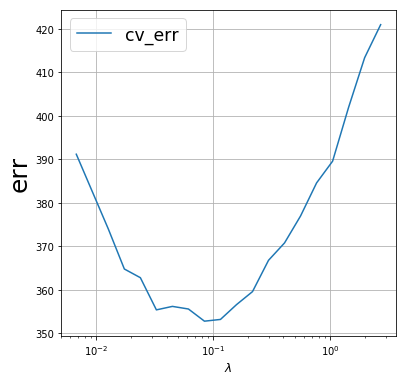

In [0]:
fg = plt.figure(figsize=(6, 6))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_linsvm, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")

Find the optimal C which minimize the out of sample misclassification rate.

In [0]:
C_opt_linsvm = C_arr[np.argmin(cv_err_linsvm)]
C_opt_linsvm

0.08427380392170362

Re-train our model based on the optimal C

In [0]:
svm_linear = svm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=C_opt_linsvm, max_iter=10000)
svm_linear.fit(X[train, :], y[train])
y_test_pred_linsvm = svm_linear.predict(X[test, :])

Since false negative is more expensive than false positive, which means we misclassify toxic comments as non-toxic, the performance of SVM model using L2 penalty does not perform very well.

In [0]:
print("Misclassification rate:", np.sum(y[test] != y_test_pred_linsvm) / float(n_test))
print("False positive:", np.sum(np.logical_and(y[test] == -1, y_test_pred_linsvm == 1)) / float(n_test_n))
print("False negative:", np.sum(np.logical_and(y[test] == 1, y_test_pred_linsvm == -1)) / float(n_test_p))

Misclassification rate: 0.0865870928585879
False positive: 0.08400993832911842
False negative: 0.12954517441143842


### 2. 5-fold CV; Logistic regression

To compare the performance of SVM and logistic regression, we use the Hinge loss for SVM, and binomial deviance for logistic regression. The binomial deviance can be viewed as a smooth approximation to the Hinge loss. So results may be close.

In [0]:
C_arr = np.exp(np.linspace(-4, 2, C_len))
cv_err_logi = np.empty(C_len)
train_cv = np.copy(train)
for i in range(C_len):
    logi = LogisticRegression(penalty="l2", tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in range(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        logi.fit(X[train_cv, :], y[train_cv])
        y_pred_k = logi.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_logi[i] = tmp_err / k

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


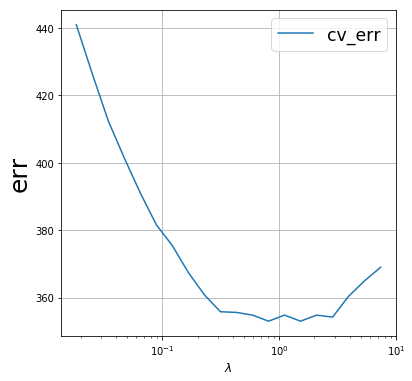

In [0]:
fg = plt.figure(figsize=(6, 6))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_logi, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")

Find the optimal C which minimize the out-of-sample misclassification rate.

In [0]:
C_opt_logi = C_arr[np.argmin(cv_err_logi)]
C_opt_logi

0.8101577349324266

Re-train our model based on the optimal C

In [0]:
logi = LogisticRegression(penalty="l2", tol=1e-5, C=C_opt_logi, max_iter=2000)
logi.fit(X[train, :], y[train])
y_test_pred_logi = logi.predict(X[test, :])

The performance of SVM and logistic regression is very similar, both have ~0.13 false negative rate and ~0.08 false positive rate.

In [0]:
print("Misclassification rate", np.sum(y[test] != y_test_pred_logi) / float(n_test))
print("False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred_logi == 1)) / float(n_test_n))
print("False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred_logi == -1)) / float(n_test_p))

Misclassification rate 0.08657314070053786
False positive 0.08404691127970776
False negative 0.12868236164180943


### imbalanced data, using cascades or increase false negative cost

## Multi-category Classification

We can still use the prepared split of training and test data, but instead of using binary y, we use the original y with 6 categories.

### 1. Logistic Regression

In [0]:
C_arr = np.exp(np.linspace(-5, 1, C_arr_len))
cv_err_linsvm = np.empty(C_arr_len)
train_cv = np.copy(train)
score_C = []
for i in range(C_arr_len):
    svm_linear_multi = svm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=C_opt_linsvm, max_iter=10000)
    
    for j in range(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        clf.fit(X[train_cv, :], y_raw[train_cv, :])
        y_pred_k = svm_linear.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_linsvm[i] = tmp_err / k

In [0]:
train_cv = np.copy(train)
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


svm_linear_multi = svm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=0.08427380392170362, max_iter=10000, multi_class='ovr')
train_cv[train_idx[cv_grid[0] : cv_grid[ 1]]] = False
svm_linear_multi.fit(X[train_cv, :], y_raw[train_cv])
j = 0
y_pred_k = svm_linear_multi.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])


ValueError: ignored

In [30]:
test = pd.read_csv(file_path + 'test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
submission = pd.read_csv(file_path + 'sample_submission.csv')

In [32]:
submission.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


Tune penalty term

In [0]:
C_len = 20
C_arr = np.exp(np.linspace(-4, 2, C_len))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

submission = pd.DataFrame.from_dict({'id': dat_test['id']})

cv_score = np.zeros((C_len,6))
  
for i in range(C_len):
  
    
    for j in range(len(class_names)):

      train_target = y_raw[class_names[j]]
      log_0 = LogisticRegression(penalty="l2", tol=1e-5, C=C_arr[i], max_iter=1000, solver='sag')  # solver = 'sag' supports multinomial loss
      
      score = np.mean(cross_val_score(log_0, X, train_target, cv = 3, scoring='roc_auc'))
      cv_score[i][j] = score


In [0]:
cv_score_pd = pd.DataFrame(cv_score, columns = class_names)
cv_score_pd

Retrain the model with optimal C for each corresponding column, and generate test results



In [0]:
scores_log = []
submission_2 = pd.DataFrame.from_dict({'id': dat_test['id']})
for class_name in class_names:
    train_target = y_raw[class_name]
    C_opt_log0= C_arr[np.argmax(cv_score_pd[class_name])]
    classifier = LogisticRegression(C = C_opt_log0, solver='sag')

    score = np.mean(cross_val_score(classifier, X, train_target, cv=3, scoring='roc_auc'))
    scores_log.append(score)
    print('CV score for class {} is {}'.format(class_name, scores_log))

    classifier.fit(X, train_target)
    submission_2[class_name] = classifier.predict_proba(X_test)[:, 1]

print('Total CV score is {}'.format(np.mean(scores_log))

submission_2.to_csv(file_path + 'submission_2.csv', index=False)

### 2. SVM

In [0]:
C_len = 20
C_arr = np.exp(np.linspace(-5, 1, C_arr_len))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


cv_score_svm = np.zeros((C_len,6))
  
for i in range(C_len):
  
    
    for j in range(len(class_names)):

      train_target = y_raw[class_names[j]]
      svm_0 = svm.LinearSVC(penalty="l2", tol=1e-5, C=C_arr[i], max_iter=1000)  # solver = 'sag' supports multinomial loss
      
      score = np.mean(cross_val_score(svm_0, X, train_target, cv = 3, scoring='roc_auc'))
      cv_score_svm[i][j] = score
     
      
      

In [0]:
cv_score_svm_pd = pd.DataFrame(cv_score_svm, columns = class_names)
cv_score_svm_pd

In [0]:
scores_svm = []
submission_3 = pd.DataFrame.from_dict({'id': dat_test['id']})

for class_name in class_names:
    train_target = y_raw[class_name]
    C_opt_svm0= C_arr[np.argmax(cv_score_svm_pd[class_name])]
    classifier = svm.LinearSVC(C = C_opt_svm0)

    score = np.mean(cross_val_score(classifier, X, train_target, cv=3, scoring='roc_auc'))
    scores_svm.append(score)
    print('CV score for class {} is {}'.format(class_name, scores_svm))

    classifier.fit(X, train_target)
    submission_3[class_name] = classifier.predict_proba(X_test)[:, 1]

print('Total CV score is {}'.format(np.mean(scores_svm)))

submission_3.to_csv('drive/My Drive/Colab_Notebooks/submission_3.csv', index=False)